In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from hnlp_proj.loader import load_ynet
from hnlp_proj.utils import extract_authors, flip_hebrew_text, combine_texts, clean_texts
from hnlp_proj.plot_utils import plot_hebrew_barchart


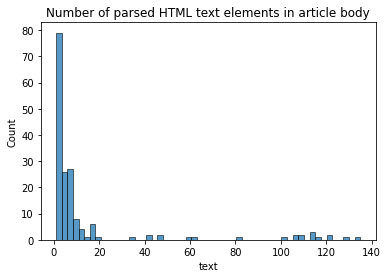

In [2]:
texts = load_ynet()

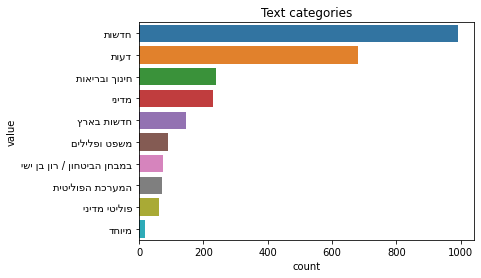

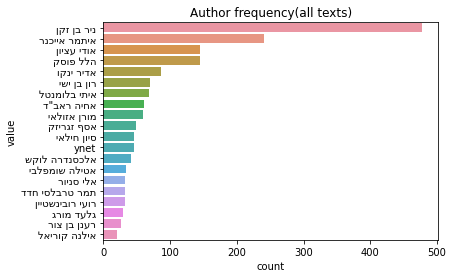

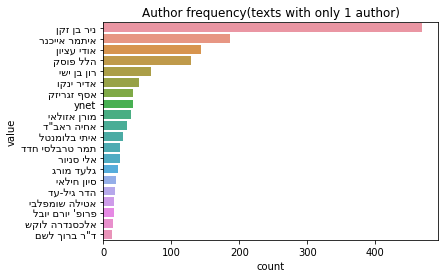

In [3]:
# Plotting frequency of categories
plot_hebrew_barchart(texts.category, 20, title="Text categories")

# Plotting author frequency of texts
NUM_AUTHORS = 20
texts.authors = texts.authors.apply(extract_authors)
plot_hebrew_barchart(texts.authors, NUM_AUTHORS, title="Author frequency(all texts)")

# find all texts that only have 1 author
one_author_df = texts[texts.authors.str.len() == 1].copy()
one_author_df["authors"]  = one_author_df["authors"].apply(lambda ls: ls[0])
one_author_df.rename(columns={"authors": "author"}, inplace=True)
plot_hebrew_barchart(one_author_df.author, NUM_AUTHORS, title="Author frequency(texts with only 1 author)")

In [4]:
print(f"Out of {len(texts)} articles, {len(one_author_df)} of them were written by exactly 1 author")

Out of 2607 articles, 1900 of them were written by exactly 1 author


In [5]:
# find texts with no author(Faulty parsing?)
no_author_df = texts[texts.authors.str.len() == 0]
no_author_df.fmt.value_counts()
no_author_df.iloc[0].text

'ארצות הברית אישרה בימים האחרונים העברת עשרות מיליוני דולרים נוספים לפלסטינים, לאחר שהנשיא החדש ג\'ו ביידן חידש את התמיכה שנפסקה בימי הנשיא הקודם דונלד טראמפ. ביום חמישי האחרון הודיעה שגרירת ארה"ב באו"ם לינדה תומס גרינפילד על והערב (ד\') דיווחה סוכנות הידיעות AP כי יום לאחר מכן עדכן הממשל האמריקני את הקונגרס על סכום של 75 מיליון דולר שיועברו לפלסטינים. בניגוד לתמיכה הראשונית, ממשל ביידן לא פרסם את דבר העברת אותם 75 מיליון דולר ועדיין לא ברור אם 15 מיליון הדולר כלולים בתוכם או שמדובר בתמיכה נוספת. על פי הודעת הממשל לקונגרס, חלק מהכספים הועברו או יועברו בקרוב. הם לא יגיעו ישירות לרשות הפלסטינית, אלא מיועדים לפרויקטים הומניטריים וכלכלים דחופים בגדה וברצועה. מדובר בחלק משינוי המגמה של ארצות הברית ביחסה אל המזרח התיכון תחת הנשיא ביידן. התמיכה הכלכלית מיועדת ככל הנראה על מנת לעודד את הפלסטינים לשוב אל שולחן המשא ומתן עם ישראל, אם יהיה כזה. ביום חמישי כינתה השגרירה תומס גרינפילד את הסיוע כחידוש המחויבות עבור העם הפלסטיני: "הסיוע יעזור לפלסטינים במצוקה קשה ויביא יותר יציבות וביטחון גם לישראלים

In [47]:
from hnlp_proj.delta import create_feature_matrix, add_count_column, combine_texts_by_author
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import f1_score, auc, accuracy_score, balanced_accuracy_score

RANDOM_STATE = 0
NUM_AUTHORS = 2
NUM_FEATURES = 50

# choose some of the most prolific authors
most_prolific_authors = one_author_df.author.value_counts()[:NUM_AUTHORS].index


# split one-author dataset to train and test
X_train, X_test = train_test_split(one_author_df.set_index("author").loc[most_prolific_authors].reset_index(), random_state=RANDOM_STATE)


X_train = create_feature_matrix(X_train, num_features=NUM_FEATURES)
X_test = create_feature_matrix(X_test, features=X_train.columns, combine_by_author=False)
#X_train.dropna(inplace=True)
y_train = X_train.index
y_test = X_test.index


knn = KNeighborsClassifier(n_neighbors=1, metric="manhattan")
knn.fit(X_train, y_train)

print(f"Score using features: {set(X_train.columns)}")

y_pred = knn.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred, labels=most_prolific_authors, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")


Score using features: {'יהיה', 'כי', 'כדי', 'היא', 'יש', 'בנפח', 'שניות', 'ללא', 'בין', '-', 'כמו', 'בישראל', '.', 'ישראל', 'גם', 'כ"ס', 'כל', 'אך', 'מנוע', 'רק', 'קמ"ש', 'עם', 'אנחנו', 'הוא', 'לא', 'מה', 'של', 'פחות', 'לפני', 'הנעה', 'או', 'החוץ', 'עוד', 'מערכת', 'אלף', ',', 'ס"מ', 'רכב', 'כאן', 'על', 'יותר', 'בסיס', 'את', 'הילוכים', 'עד', 'תא', 'אם', 'ליטר', 'אבל', 'זה'}
F1 score: 0.8537576839183026
Accuracy: 0.8475609756097561
Balanced Accuracy: 0.8913043478260869
